In [223]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import torch
from torch import nn
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset

pd.set_option('display.max_rows', 12)

In [237]:
train =  pd.read_csv("demand-forecasting-kernels-only/train.csv", parse_dates=['date'], index_col="date")
test =  pd.read_csv("demand-forecasting-kernels-only/test.csv", parse_dates=['date'], index_col="date")
sub =  pd.read_csv("demand-forecasting-kernels-only/sample_submission.csv")

In [238]:
def expand_df(df):
    data = df.copy()
    data['day'] = data.index.day
    data['month'] = data.index.month
    data['year'] = data.index.year
    data['dayofweek'] = data.index.dayofweek
    return data

train = expand_df(train)
test = expand_df(test)

In [239]:
train

,store,item,sales,day,month,year,dayofweek
date,,,,,,,
2013-01-01,1,1,13,1,1,2013,1
2013-01-02,1,1,11,2,1,2013,2
2013-01-03,1,1,14,3,1,2013,3
2013-01-04,1,1,13,4,1,2013,4
2013-01-05,1,1,10,5,1,2013,5
...,...,...,...,...,...,...,...
2017-12-27,10,50,63,27,12,2017,2
2017-12-28,10,50,59,28,12,2017,3
2017-12-29,10,50,74,29,12,2017,4


In [240]:
# train中选出2013-2016做训练集，2017做验证集
train_set = train[train['year'] < 2017]
validation_set = train[train['year'] == 2017]

# Base Model

In [241]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from sklearn.pipeline import make_pipeline

### 整体 tree regression

In [242]:
# X_train, X_val, y_train, y_val = train_test_split(X,y, shuffle=False, test_size=0.2)
X_train = train_set.drop('sales', axis=1)
y_train = train_set['sales']
X_val = validation_set.drop('sales', axis=1)
y_val = validation_set['sales']

In [243]:
X_train

,store,item,day,month,year,dayofweek
date,,,,,,
2013-01-01,1,1,1,1,2013,1
2013-01-02,1,1,2,1,2013,2
2013-01-03,1,1,3,1,2013,3
2013-01-04,1,1,4,1,2013,4
2013-01-05,1,1,5,1,2013,5
...,...,...,...,...,...,...
2016-12-27,10,50,27,12,2016,1
2016-12-28,10,50,28,12,2016,2
2016-12-29,10,50,29,12,2016,3


In [244]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [245]:
X_train

array([[-1.5666989 , -1.69774938, -1.67380491, -1.6014511 , -1.34219223,
        -1.00085668],
       [-1.5666989 , -1.69774938, -1.56016973, -1.6014511 , -1.34219223,
        -0.50042834],
       [-1.5666989 , -1.69774938, -1.44653456, -1.6014511 , -1.34219223,
         0.        ],
       ...,
       [ 1.5666989 ,  1.69774938,  1.50798   ,  1.58815364,  1.34035613,
         0.        ],
       [ 1.5666989 ,  1.69774938,  1.62161517,  1.58815364,  1.34035613,
         0.50042834],
       [ 1.5666989 ,  1.69774938,  1.73525035,  1.58815364,  1.34035613,
         1.00085668]])

In [246]:
# reg = make_pipeline(PolynomialFeatures(2), LinearRegression())
# reg.fit(X_train, y_train)

# reg = SVR()
# reg.fit(X_train, y_train)

reg = DecisionTreeRegressor()
reg.fit(X_train, y_train)

DecisionTreeRegressor()

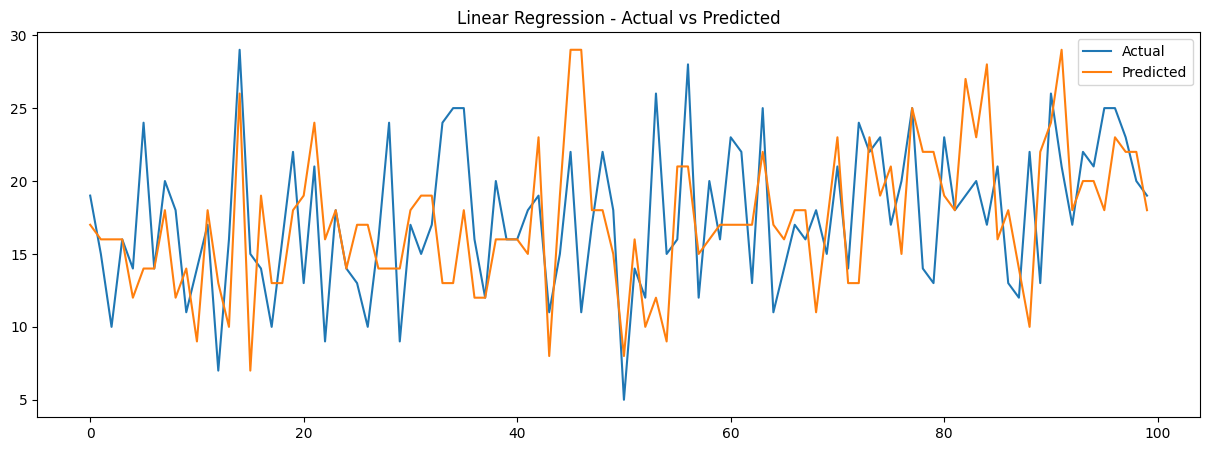

Linear Regression MSE: 125.96835068493151


In [247]:
# Predict on validation set
y_val_pred_lr = reg.predict(X_val)

# Plot actual vs predicted
plt.figure(figsize=(15, 5))
plt.plot(y_val.values[:100], label='Actual')
plt.plot(y_val_pred_lr[:100], label='Predicted')
plt.title('Linear Regression - Actual vs Predicted')
plt.legend()
plt.show()

rmse = mean_squared_error(y_val.values, y_val_pred_lr)
print(f'Linear Regression MSE: {rmse}')

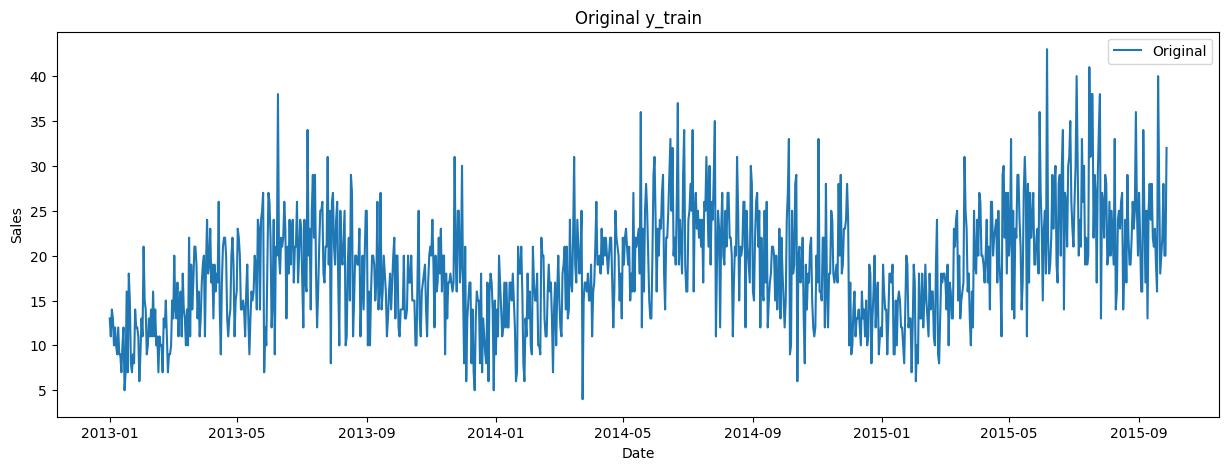

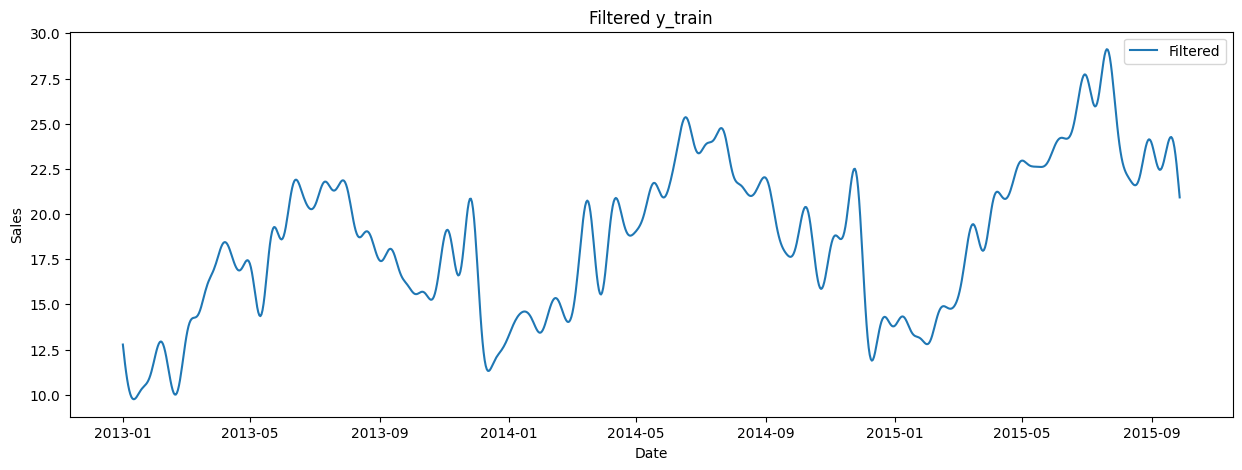

In [248]:
import numpy as np
from scipy.signal import butter, filtfilt
import numpy as np
from scipy.fft import fft, ifft

import matplotlib.pyplot as plt

# Plot y_train
plt.figure(figsize=(15, 5))
plt.plot(y_train[:1000].index, y_train[:1000].values, label='Original')
plt.title('Original y_train')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

# Apply low-pass filter
def butter_lowpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def apply_lowpass_filter(data, cutoff_freq, fs):
    b, a = butter_lowpass(cutoff_freq, fs)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

# Define cutoff frequency and sampling frequency
cutoff_freq = 1/20  # 7 days
fs = 1  # Assuming daily data

# Apply low-pass filter to y_train
filtered_y_train = apply_lowpass_filter(y_train.values, cutoff_freq, fs)

# Plot filtered y_train
plt.figure(figsize=(15, 5))
plt.plot(y_train[:1000].index, filtered_y_train[:1000], label='Filtered')
plt.title('Filtered y_train')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

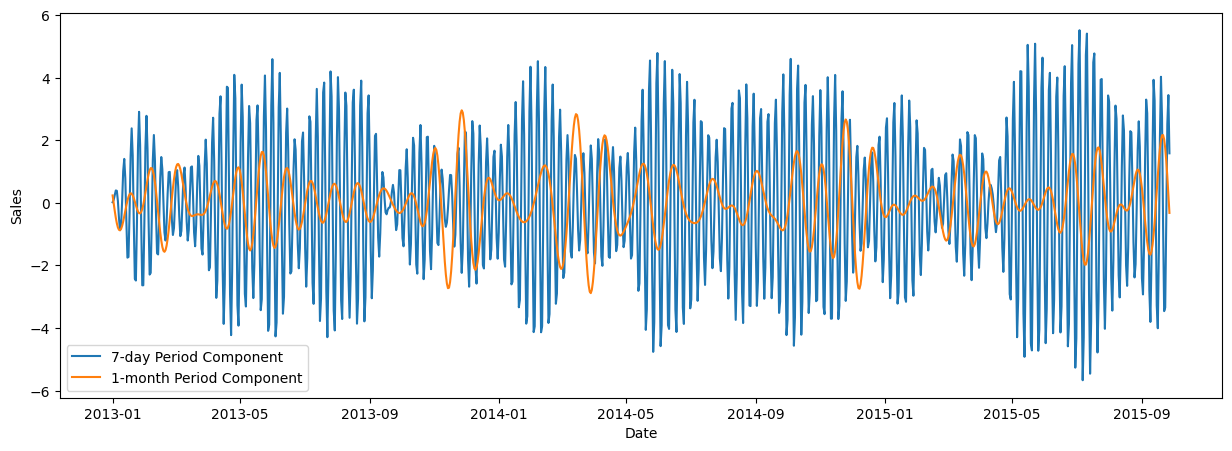

In [250]:
from scipy.signal import butter, filtfilt

# Define a bandpass filter function
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def apply_bandpass_filter(data, lowcut, highcut, fs):
    b, a = butter_bandpass(lowcut, highcut, fs)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

# Define the frequency range for the 7-day period component
# Since the period is 7 days, the frequency is 1/7 per day
# To capture just around this frequency, we define a small range around it
lowcut = 1/8  # Slightly lower than the 7-day frequency
highcut = 1/6  # Slightly higher than the 7-day frequency
fs = 1  # Assuming daily data

# Apply bandpass filter to y_train to isolate the 7-day period component
filtered_7day_y_train = apply_bandpass_filter(y_train.values, lowcut, highcut, fs)
filtered_month_y_train = apply_bandpass_filter(y_train.values, 1/40, 1/20, fs)
# filtered_year_y_train = apply_bandpass_filter(y_train.values, 1/400, 1/50, fs)

# Plot the 7-day period component of y_train
plt.figure(figsize=(15, 5))
plt.plot(y_train[:1000].index, filtered_7day_y_train[:1000], label='7-day Period Component')
plt.plot(y_train[:1000].index, filtered_month_y_train[:1000], label='1-month Period Component')
# plt.plot(y_train[:1000].index, filtered_year_y_train[:1000], label='1-year Period Component')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [251]:
# reg = make_pipeline(PolynomialFeatures(2), LinearRegression())
# reg.fit(X_train, y_train)

# reg = SVR()
# reg.fit(X_train, y_train)

reg = DecisionTreeRegressor()
reg.fit(X_train, filtered_y_train)

reg2 = DecisionTreeRegressor()
reg2.fit(X_train, filtered_7day_y_train)

reg3 = DecisionTreeRegressor()
reg3.fit(X_train, filtered_month_y_train)

DecisionTreeRegressor()

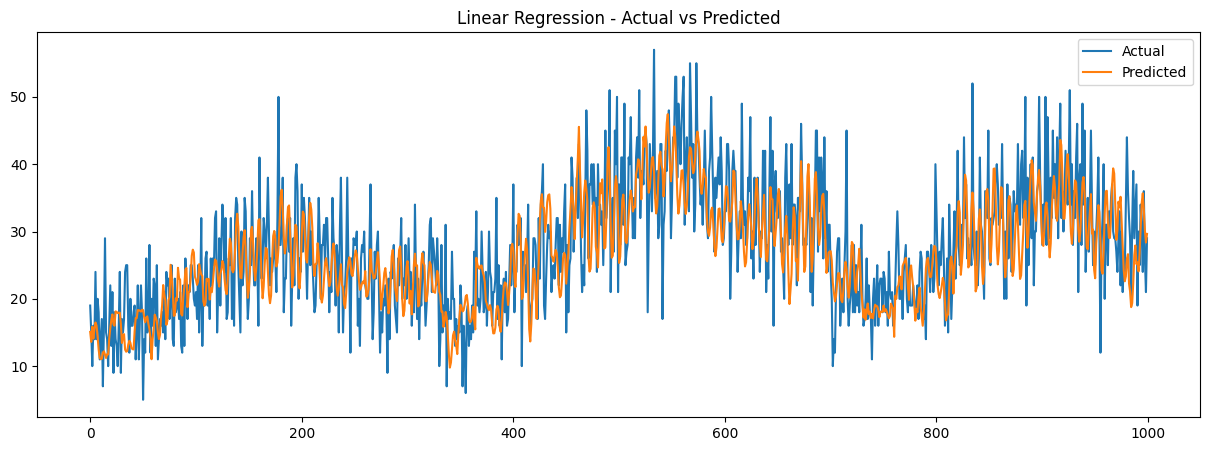

Linear Regression MSE: 116.02905045465737


In [252]:
# Predict on validation set
y_val_pred_lr = reg.predict(X_val) + reg2.predict(X_val) + reg3.predict(X_val)

# Plot actual vs predicted
plt.figure(figsize=(15, 5))
plt.plot(y_val.values[:1000], label='Actual')
plt.plot(y_val_pred_lr[:1000], label='Predicted')
plt.title('Tree Regression - Actual vs Predicted')
plt.legend()
plt.show()

rmse = mean_squared_error(y_val.values, y_val_pred_lr)
print(f'Tree Regression MSE: {rmse}')

### Linear Regression

In [268]:
X_train = train_set.drop('sales', axis=1)
y_train = train_set['sales']
X_val = validation_set.drop('sales', axis=1)
y_val = validation_set['sales']

In [158]:
reg = make_pipeline(
    PolynomialFeatures(degree=2),
    LinearRegression()
)
reg.fit(X_train, y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

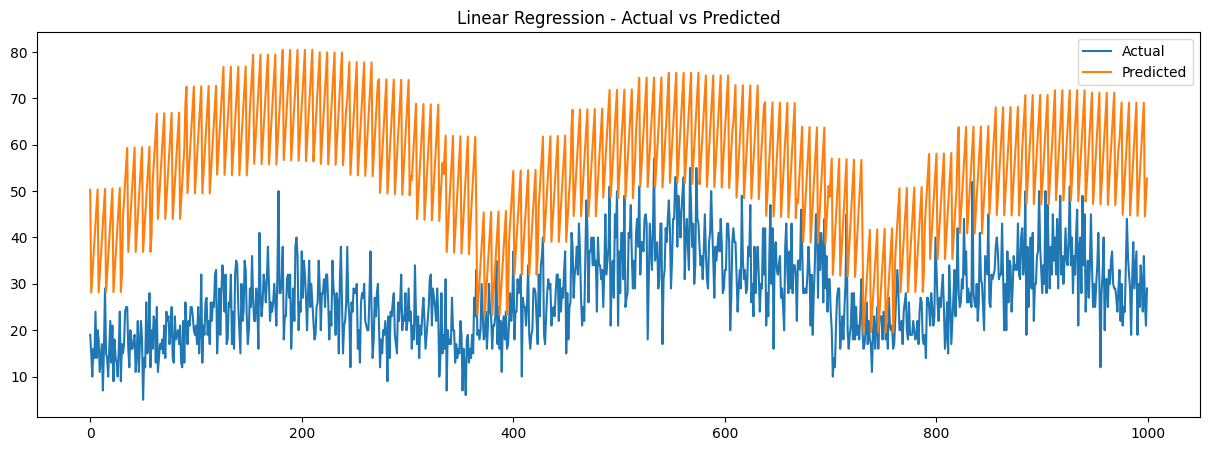

Linear Regression MSE: 783.7418384799917


In [161]:
# Predict on validation set
y_val_pred_lr = reg.predict(X_val)

# Plot actual vs predicted
plt.figure(figsize=(15, 5))
plt.plot(y_val.values[0:1000], label='Actual')
plt.plot(y_val_pred_lr[0:1000], label='Predicted')
plt.title('Linear Regression - Actual vs Predicted')
plt.legend()
plt.show()

rmse = mean_squared_error(y_val.values, y_val_pred_lr)
print(f'Linear Regression MSE: {rmse}')

### 单个store, item

In [254]:
from tqdm import tqdm

In [111]:
X_val = validation_set.drop('sales', axis=1)
y_val = validation_set['sales']

In [259]:
regs = {}
# Apply low-pass filter
def butter_lowpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def apply_lowpass_filter(data, cutoff_freq, fs):
    b, a = butter_lowpass(cutoff_freq, fs)
    filtered_data = filtfilt(b, a, data)
    return filtered_data



for j in train_set.item.unique():
    for i in train_set.store.unique():
        train_per_store_item = train_set.query(f"store == {i} and item == {j}")
        X_train = train_per_store_item.drop('sales', axis=1)
        y_train = train_per_store_item['sales']
        # Define cutoff frequency and sampling frequency
        cutoff_freq = 1/7  # 7 days
        fs = 1  # Assuming daily data
        # Apply low-pass filter to y_train
        filtered_y_train = apply_lowpass_filter(y_train.values, cutoff_freq, fs)
        regs[f"{i}_{j}"] = DecisionTreeRegressor()
        regs[f"{i}_{j}"].fit(X_train, filtered_y_train)
        print(f"Trained model for store {i} and item {j}")

Trained model for store 1 and item 1
Trained model for store 2 and item 1
Trained model for store 3 and item 1
Trained model for store 4 and item 1
Trained model for store 5 and item 1
Trained model for store 6 and item 1
Trained model for store 7 and item 1
Trained model for store 8 and item 1
Trained model for store 9 and item 1
Trained model for store 10 and item 1
Trained model for store 1 and item 2
Trained model for store 2 and item 2
Trained model for store 3 and item 2
Trained model for store 4 and item 2
Trained model for store 5 and item 2
Trained model for store 6 and item 2
Trained model for store 7 and item 2
Trained model for store 8 and item 2
Trained model for store 9 and item 2
Trained model for store 10 and item 2
Trained model for store 1 and item 3
Trained model for store 2 and item 3
Trained model for store 3 and item 3
Trained model for store 4 and item 3
Trained model for store 5 and item 3
Trained model for store 6 and item 3
Trained model for store 7 and item 3

In [260]:
def predict_per_store_item(regs, data):
    pred_val = []
    for j in data.item.unique():
        for i in data.store.unique():
            model = regs[f"{i}_{j}"]
            pred_sales = model.predict(data.query(f"store == {i} and item == {j}"))
            pred_val.extend(list(pred_sales))
            print(f"Predicted for store {i} and item {j}")
    return pred_val

Predicted for store 1 and item 1
Predicted for store 2 and item 1
Predicted for store 3 and item 1
Predicted for store 4 and item 1
Predicted for store 5 and item 1
Predicted for store 6 and item 1
Predicted for store 7 and item 1
Predicted for store 8 and item 1
Predicted for store 9 and item 1
Predicted for store 10 and item 1
Predicted for store 1 and item 2
Predicted for store 2 and item 2
Predicted for store 3 and item 2
Predicted for store 4 and item 2
Predicted for store 5 and item 2
Predicted for store 6 and item 2
Predicted for store 7 and item 2
Predicted for store 8 and item 2
Predicted for store 9 and item 2
Predicted for store 10 and item 2
Predicted for store 1 and item 3
Predicted for store 2 and item 3
Predicted for store 3 and item 3
Predicted for store 4 and item 3
Predicted for store 5 and item 3
Predicted for store 6 and item 3
Predicted for store 7 and item 3
Predicted for store 8 and item 3
Predicted for store 9 and item 3
Predicted for store 10 and item 3
Predict

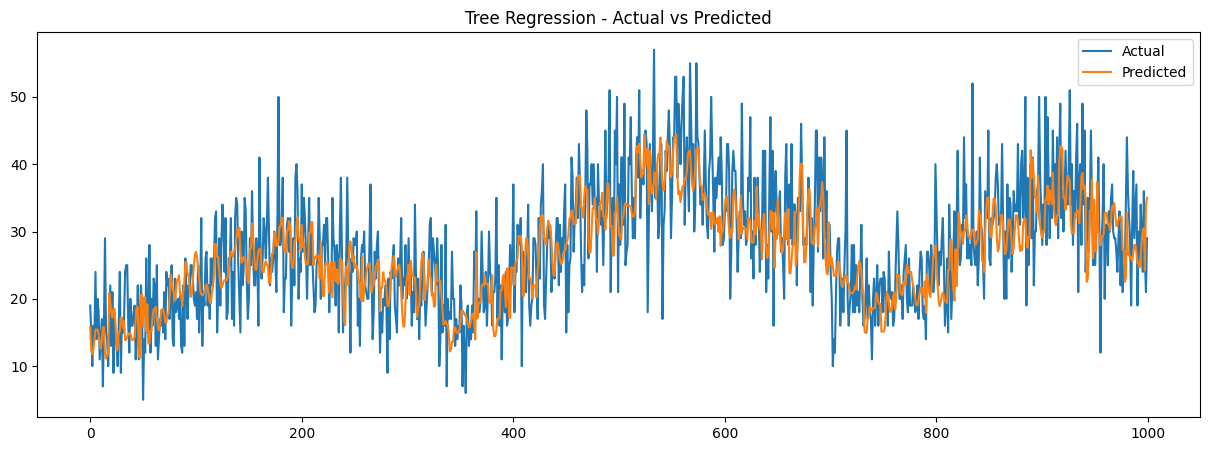

Tree Regression MSE: 118.33406508512813


In [269]:
# Predict on validation set
y_val_pred_lr = predict_per_store_item(regs, X_val)
y_val = y_val

# Plot actual vs predicted
plt.figure(figsize=(15, 5))
plt.plot(y_val.values[:1000] , label='Actual')
plt.plot(y_val_pred_lr[:1000], label='Predicted')
plt.title('Tree Regression - Actual vs Predicted')
plt.legend()
plt.show()

mse = mean_squared_error(y_val.values, y_val_pred_lr)
print(f'Tree Regression MSE: {mse}')

## Linear Regression 2

From the analysis, we have different items and stores follow the similaer pattern of Changing with time, so we build a multi-stage LR Model here to predict the sale.

It consists of a three-stage LR model:
1. Model $LR_1$ use the year $y$, item $i$, and store $j$ to predict $E[S_{ij}^{y}]$
2. Model $LR_2$ use $E[S_{ij}^{y}]$, the month $m$, item $i$, and store $j$ to predict $E[S_{ij}^{ym}]$
2. Model $LR_3$ use $E[S_{ij}^{ym}]$, the day $d$, item $i$, and store $j$ to predict $E[S_{ij}^{ymd}]$

the final model is 

$$
LR_{final}(d, m, y, i, j) := LR_3(d, i, j, LR_2(m, i, j, LE_1(y, i, j)))
$$

In [16]:
train_set_avg_year = train_set.groupby(['year', 'store', 'item'])['sales'].mean().reset_index()
val_set_avg_year = validation_set.groupby(['year', 'store', 'item'])['sales'].mean().reset_index()

In [ ]:
grand_avg = train_set.sales.mean()

In [17]:
X_train_1 = train_set_avg_year.drop('sales', axis=1)
y_train_1 = train_set_avg_year['sales'] / grand_avg
X_val_1 = val_set_avg_year.drop('sales', axis=1)
y_val_1 = val_set_avg_year['sales'] / grand_avg

In [29]:
# X_train_1 = train_set_avg_year[['year', 'item', 'store']].values
# scaler = StandardScaler()
# # Fit the scaler and transform X_train_1
# X_train_1 = scaler.fit_transform(X_train_1)

# y_train_1 = train_set_avg_year['sales'].values

In [18]:
scaler = StandardScaler()
X_train_1 = scaler.fit_transform(X_train_1)
X_val_1 = scaler.transform(X_val_1)

In [23]:
reg_1 = LinearRegression()
reg_1.fit(X_train_1, y_train_1)

LinearRegression()

In [24]:
LR_1_pred = reg_1.predict(X_val_1)

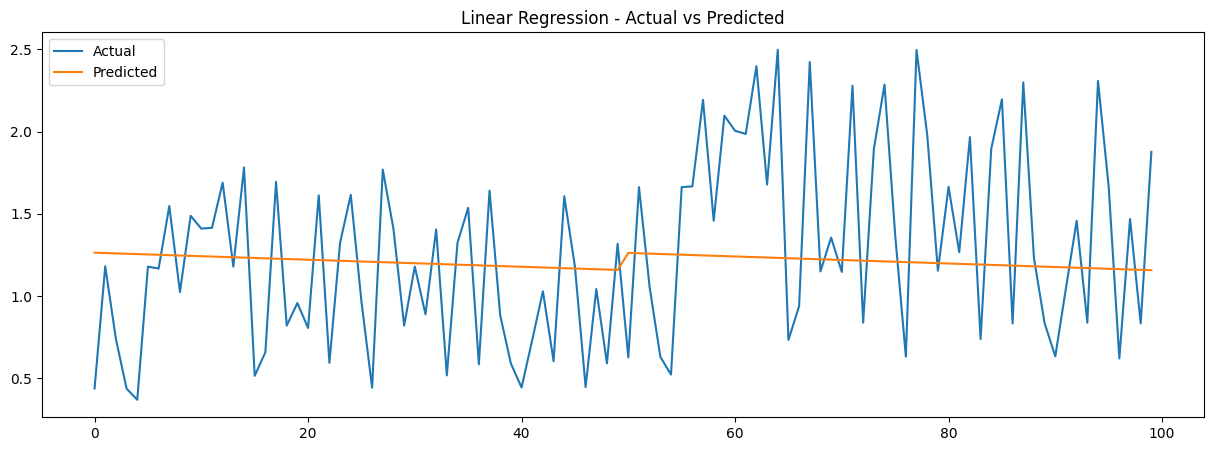

Linear Regression MSE: 0.2863283935482254


In [25]:
# Plot actual vs predicted
plt.figure(figsize=(15, 5))
plt.plot(y_val_1.values[:100], label='Actual')
plt.plot(LR_1_pred[:100], label='Predicted')
plt.title('Linear Regression - Actual vs Predicted')
plt.legend()
plt.show()

rmse = mean_squared_error(y_val_1, LR_1_pred)
print(f'Linear Regression MSE: {rmse}')

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Define the models
LR_1 = DecisionTreeRegressor()
LR_2 = DecisionTreeRegressor()
LR_3 = DecisionTreeRegressor()

# Calculate average sales for each combination of 'year', 'item', 'store', 'month', and 'day'
train_set_grouped = train_set.groupby(['year', 'item', 'store', 'month', 'day'])['sales'].mean().reset_index()

# Fit LR_1
X_train_1 = train_set_grouped[['year', 'item', 'store']]
y_train_1 = train_set_grouped['sales']
LR_1.fit(X_train_1, y_train_1)

# Use predictions from LR_1 to fit LR_2
train_set_grouped.loc[:, 'E(S_{ij}^{y})'] = LR_1.predict(X_train_1)
X_train_2 = train_set_grouped[['E(S_{ij}^{y})', 'month', 'item', 'store']]
y_train_2 = train_set_grouped['sales']
LR_2.fit(X_train_2, y_train_2)

# Use predictions from LR_2 to fit LR_3
train_set_grouped.loc[:, 'E(S_{ij}^{ym})'] = LR_2.predict(X_train_2)
X_train_3 = train_set_grouped[['E(S_{ij}^{ym})', 'day', 'item', 'store']]
y_train_3 = train_set_grouped['sales']
LR_3.fit(X_train_3, y_train_3)

DecisionTreeRegressor()

In [23]:
# Evaluate the final model on validation_set
validation_set['E(S_{ij}^{y})'] = LR_1.predict(validation_set[['year', 'item', 'store']])
validation_set['E(S_{ij}^{ym})'] = LR_2.predict(validation_set[['E(S_{ij}^{y})', 'month', 'item', 'store']])
X_val = validation_set[['E(S_{ij}^{ym})', 'day', 'item', 'store']]
y_val = validation_set['sales']
y_pred = LR_3.predict(X_val)

# Calculate RMSE
mse = mean_squared_error(y_val, y_pred)
print(f'MSE: {mse}')

RMSE: 237.2787293759513


/tmp/ipykernel_268658/2969323509.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_set['E(S_{ij}^{y})'] = LR_1.predict(validation_set[['year', 'item', 'store']])
/tmp/ipykernel_268658/2969323509.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_set['E(S_{ij}^{ym})'] = LR_2.predict(validation_set[['E(S_{ij}^{y})', 'month', 'item', 'store']])


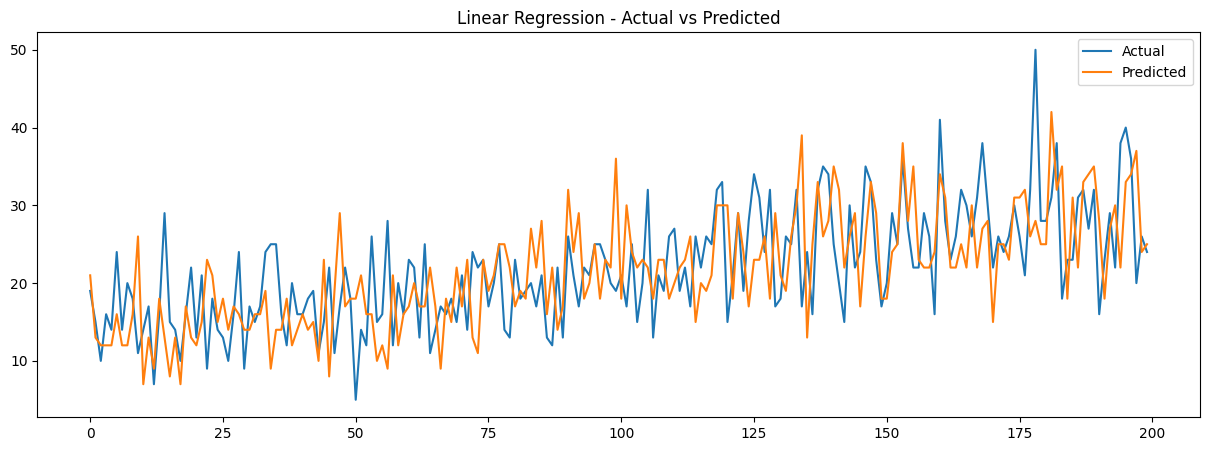

In [26]:
import matplotlib.pyplot as plt

# Plot actual vs predicted
plt.figure(figsize=(15, 5))
plt.plot(y_val.values[:200], label='Actual')
plt.plot(y_pred[:200], label='Predicted')
plt.title('Linear Regression - Actual vs Predicted')
plt.legend()
plt.show()

## RNN

In [63]:
X_train = train_set.query(f"store == 1 and item == 1").drop('sales', axis=1).values
y_train = train_set.query(f"store == 1 and item == 1")['sales'].values
X_val = validation_set.query(f"store == 1 and item == 1").drop('sales', axis=1).values
y_val = validation_set.query(f"store == 1 and item == 1")['sales'].values

# X_train = train_set.drop('sales', axis=1).values
# y_train = train_set['sales'].values
# X_val = validation_set.drop('sales', axis=1).values
# y_val = validation_set['sales'].values

In [65]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [66]:
class SalesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = SalesDataset(X_train, y_train)
val_dataset = SalesDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


In [67]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        h0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

input_size = X_train.shape[1]
hidden_size = 50
num_layers = 2

model = RNNModel(input_size, hidden_size, num_layers)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [68]:
torch.save(model, 'model.pth')

In [69]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch.unsqueeze(1))
            loss = criterion(outputs.squeeze(), y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)
        
        train_loss = train_loss / len(train_loader.dataset)
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch.unsqueeze(1))
                loss = criterion(outputs.squeeze(), y_batch)
                val_loss += loss.item() * X_batch.size(0)
        
        val_loss = val_loss / len(val_loader.dataset)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=400)

cuda
Epoch 1/400, Train Loss: 408.4426, Val Loss: 511.0227
Epoch 2/400, Train Loss: 365.2810, Val Loss: 448.2988
Epoch 3/400, Train Loss: 300.6413, Val Loss: 360.4325
Epoch 4/400, Train Loss: 227.4735, Val Loss: 278.2584
Epoch 5/400, Train Loss: 171.2410, Val Loss: 220.8592
Epoch 6/400, Train Loss: 133.9506, Val Loss: 181.4758
Epoch 7/400, Train Loss: 108.6635, Val Loss: 153.2965
Epoch 8/400, Train Loss: 90.8860, Val Loss: 132.2775
Epoch 9/400, Train Loss: 77.9742, Val Loss: 116.1125
Epoch 10/400, Train Loss: 68.4283, Val Loss: 103.4700
Epoch 11/400, Train Loss: 61.3254, Val Loss: 93.4941
Epoch 12/400, Train Loss: 56.0368, Val Loss: 85.5823
Epoch 13/400, Train Loss: 52.1033, Val Loss: 79.2842
Epoch 14/400, Train Loss: 49.1735, Val Loss: 74.2500
Epoch 15/400, Train Loss: 46.9670, Val Loss: 70.1992
Epoch 16/400, Train Loss: 45.2472, Val Loss: 66.8980
Epoch 17/400, Train Loss: 43.7993, Val Loss: 64.1417
Epoch 18/400, Train Loss: 42.4368, Val Loss: 61.7463
Epoch 19/400, Train Loss: 41.1095

In [70]:
# Convert validation data to DataLoader
# val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Get predictions
model.eval()
y_val_pred_rnn = []
with torch.no_grad():
    for X_batch, _ in val_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch.unsqueeze(1))
        y_val_pred_rnn.extend(outputs.cpu().numpy())

y_val_pred_rnn = np.array(y_val_pred_rnn).flatten()


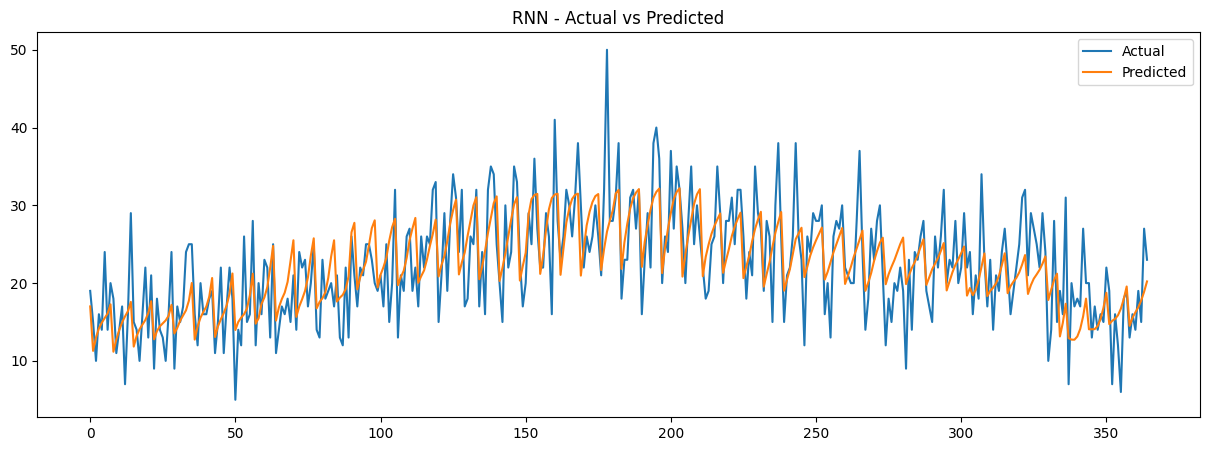

RNN MSE: 23.886742469761998


In [72]:
# Plot actual vs predicted
plt.figure(figsize=(15, 5))
plt.plot(y_val[:], label='Actual')
plt.plot(y_val_pred_rnn[:], label='Predicted')
plt.title('RNN - Actual vs Predicted')
plt.legend()
plt.show()

mse = mean_squared_error(y_val, y_val_pred_rnn)
print(f'RNN MSE: {mse}')

# Periodic decomposition 

In [235]:
train =  pd.read_csv("demand-forecasting-kernels-only/train.csv", parse_dates=['date'])
test =  pd.read_csv("demand-forecasting-kernels-only/test.csv", parse_dates=['date'])
sub =  pd.read_csv("demand-forecasting-kernels-only/sample_submission.csv")

In [ ]:
def expand_df(df):
    data = df.copy()
    data['day'] = data["date"].dt.day
    data['month'] = data["date"].dt.month
    data['year'] = data["date"].dt.year
    data['dayofweek'] = data["date"].dt.dayofweek
    return data

train = expand_df(train)
test = expand_df(test)

In [207]:
# Item-Store Look Up Table
grand_avg = train_set.sales.mean()
store_item_table = pd.pivot_table(train_set, index='store', columns='item',
                                  values='sales', aggfunc=np.mean)

/tmp/ipykernel_379062/2021421445.py:3: FutureWarning: The provided callable <function mean at 0x7f1a700a1f30> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  store_item_table = pd.pivot_table(train_set, index='store', columns='item',


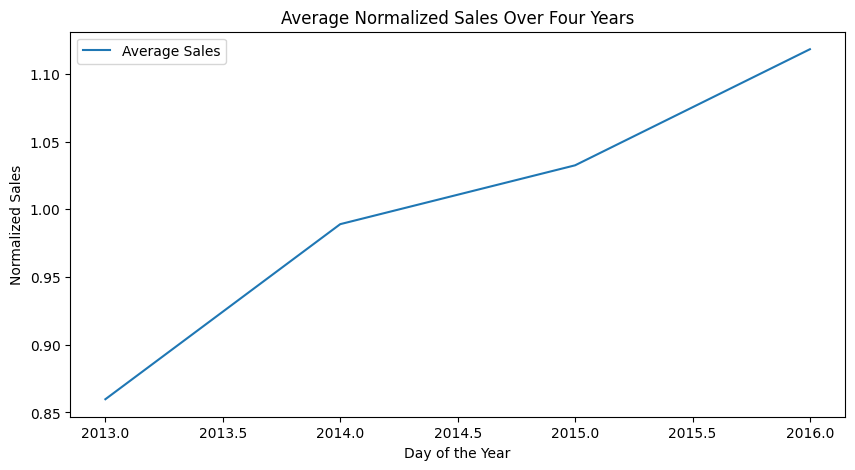

In [216]:
average_sales_per_year = train_set.groupby('year')['sales'].mean() 
normalized_sales_per_year = average_sales_per_year / grand_avg

plt.figure(figsize=(10, 5))
# Plot the average sales per day
plt.plot(normalized_sales_per_year.index, normalized_sales_per_year, label='Average Sales')

plt.xlabel('Day of the Year')
plt.ylabel('Normalized Sales')
plt.title('Average Normalized Sales Over Four Years')
plt.legend()
plt.show()

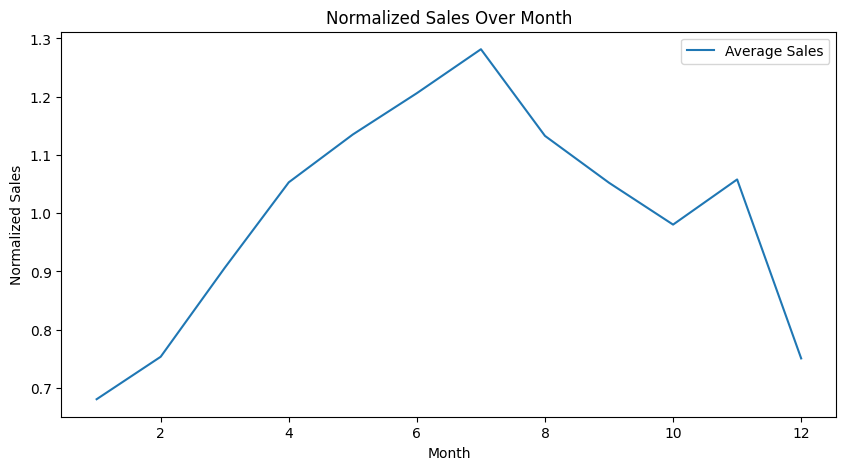

In [217]:
average_sales_per_month = train_set.groupby('month')['sales'].mean() 
normalized_sales_per_month = average_sales_per_month / grand_avg

plt.figure(figsize=(10, 5))
# Plot the average sales per day
plt.plot(normalized_sales_per_month.index, normalized_sales_per_month, label='Average Sales')

plt.xlabel('Month')
plt.ylabel('Normalized Sales')
plt.title('Normalized Sales Over Month')
plt.legend()
plt.show()

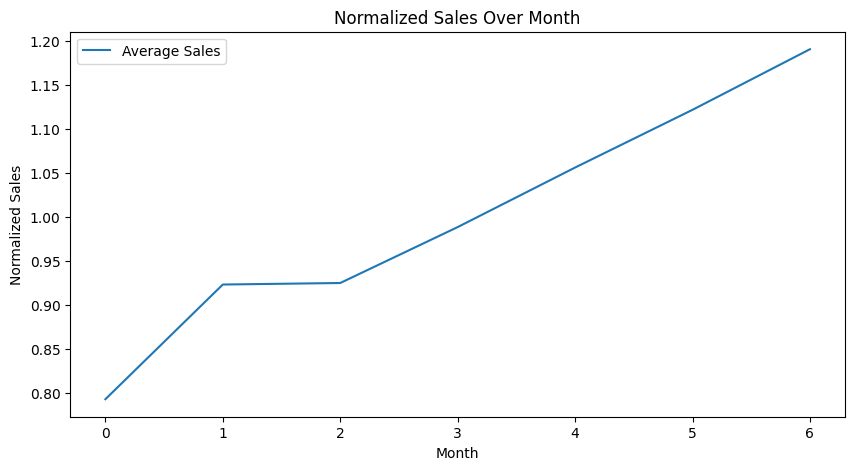

In [218]:
average_sales_per_week = train_set.groupby('dayofweek')['sales'].mean() 
normalized_sales_per_week = average_sales_per_week / grand_avg

plt.figure(figsize=(10, 5))
# Plot the average sales per day
plt.plot(normalized_sales_per_week.index, normalized_sales_per_week, label='Average Sales')

plt.xlabel('Month')
plt.ylabel('Normalized Sales')
plt.title('Normalized Sales Over Month')
plt.legend()
plt.show()

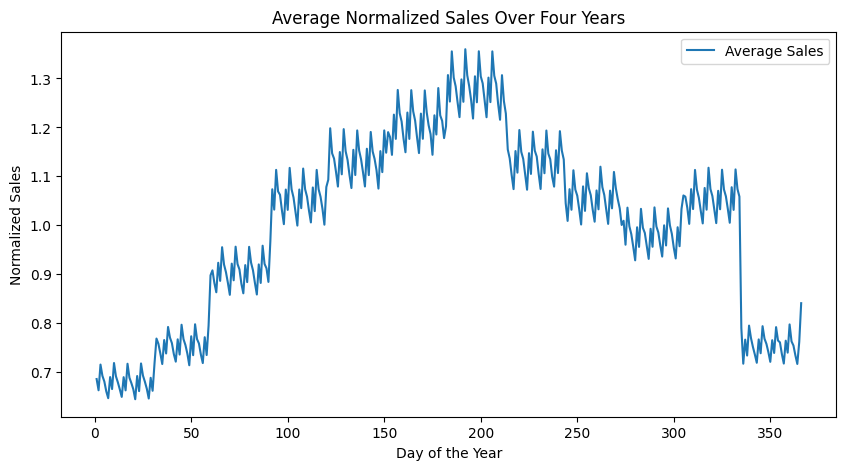

In [211]:
average_sales_per_year = train_set.groupby('year')['sales'].mean()
train['sales_normalized'] = train_set.apply(lambda row: row['sales'] / average_sales_per_year[row['year']], axis=1)
average_sales_per_day = train_set.groupby(train['date'].dt.dayofyear)['sales_normalized'].mean()

plt.figure(figsize=(10, 5))
# Plot the average sales per day
plt.plot(average_sales_per_day.index, average_sales_per_day, label='Average Sales')

plt.xlabel('Day of the Year')
plt.ylabel('Normalized Sales')
plt.title('Average Normalized Sales Over Four Years')
plt.legend()
plt.show()

In [219]:
year_table = pd.pivot_table(train_set, index='year', values='sales', aggfunc=np.mean)
year_table /= grand_avg

years = np.arange(2013, 2017)
annual_sales_avg = year_table.values.squeeze()

p2 = np.poly1d(np.polyfit(years[:], annual_sales_avg, 2))

/tmp/ipykernel_379062/4064915875.py:1: FutureWarning: The provided callable <function mean at 0x7f1a700a1f30> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  year_table = pd.pivot_table(train_set, index='year', values='sales', aggfunc=np.mean)


In [222]:
annual_growth = p2

In [220]:
def evaluate(test):
    pred_val = []
    for _, row in tqdm(test.iterrows()):
        dow, month, year = row["dayofweek"], row["month"], row["year"]
        item, store = row['item'], row['store']
        base_sales = store_item_table.at[store, item]
        mul = normalized_sales_per_month.at[month] * normalized_sales_per_week.at[dow]
        pred_sales = base_sales * mul * annual_growth(year)
        pred_val.append(pred_sales)
    return pred_val

pred_val = evaluate(validation_set.reindex())

182500it [00:17, 10545.17it/s]


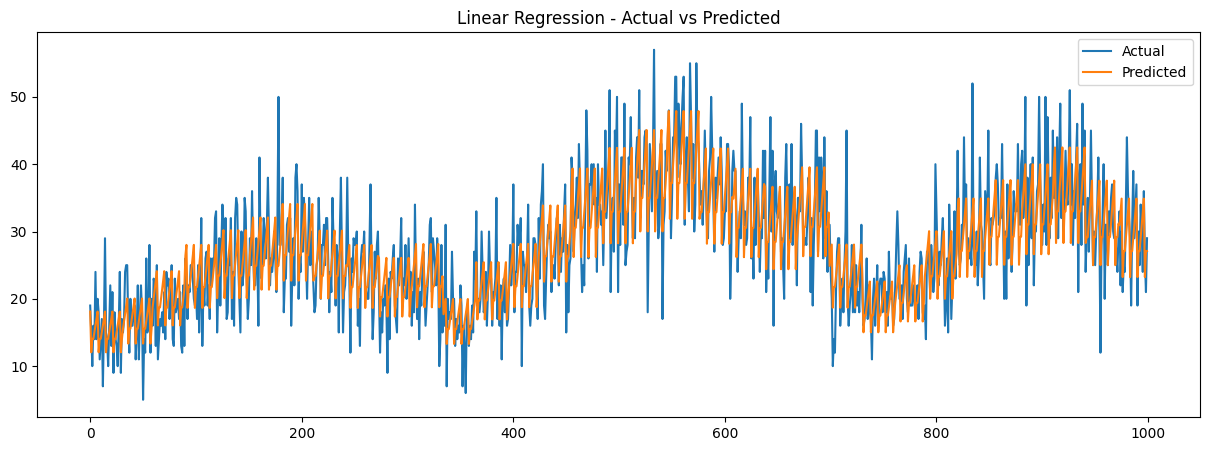

Linear Regression MSE: 59.403420375343266


In [221]:
# Plot actual vs predicted
val = validation_set["sales"].values
val_pred = pred_val

plt.figure(figsize=(15, 5))
plt.plot(val[:1000], label='Actual')
plt.plot(val_pred[:1000], label='Predicted')
plt.title('Linear Regression - Actual vs Predicted')
plt.legend()
plt.show()

rmse = mean_squared_error(val, val_pred)
print(f'Linear Regression MSE: {rmse}')